In [1]:
import mlflow
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from mlflow.models import infer_signature

### Connect to mlflow

In [2]:
tracking_uri = "http://127.0.0.1:8080"
mlflow.set_tracking_uri(tracking_uri)

In [3]:
experiment_name = "churn_prediction"
artifact_loc = "data/churn_pred_models"
tags = {
    "mlflow.note.content": f"Customer churn prediction end-to-end pipeline using mlflow",
    "team": "AI engineering team",
    "project": f"churn_prediction_end_to_end project",
}

exp = mlflow.get_experiment_by_name(experiment_name)
if exp is None:
    mlflow.create_experiment(name=experiment_name, tags=tags, artifact_location=artifact_loc)
experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

### Load dataset for training model


In [29]:
X_train = np.load("../src/data/X_train_scaled.npy")
X_test = np.load("../src/data/X_test_scaled.npy")
y_train = np.load("../src/data/y_train.npy", allow_pickle=True)
y_test = np.load("../src/data/y_test.npy", allow_pickle=True)

### Mlflow helper function

In [128]:
run_name = "churn_pred"

def mlflow_logging(params, metrics, model_name, sk_model):
    with mlflow.start_run(run_name=run_name, experiment_id=experiment_id):

        # Log to mlflow
        for key, val in params.items():
            mlflow.log_param(key=key, value=val)

        for key, val in metrics.items():
            mlflow.log_metric(key=key, value=val)

        tags = {
            "mlflow.note.content": f"{model_name} training outcome",
            "model_name": model_name
        }

        for key, val in tags.items():
            mlflow.set_tag(key=key, value=val)

        mlflow.sklearn.log_model(
            sk_model=sk_model, 
            input_example=X_test[:5],
            registered_model_name=f"{model_name}_models", 
            signature=infer_signature(X_train[:10], sk_model.predict(X_test[:5])),
            name=f"{model_name}_artifact",
        )
        
        print(f"✅ Done logging {model_name}")

In [5]:
rs = 42 # Random state

### Let's build a base model using decision tree

In [30]:
model_name = "decision_tree"

# Train out model
dtc_m1_params = {"max_depth":None, "criterion":'gini', "random_state":rs}
dtc_m1_model = DecisionTreeClassifier(**dtc_m1_params)

dtc_m1_model = dtc_m1_model.fit(X=X_train, y=y_train)
y_pred = dtc_m1_model.predict(X=X_test)

# Metrics
dtc_m1_metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred)
}

print(dtc_m1_metrics)
# Logging to mlflow
# mlflow_logging(dtc_m1_params, dtc_m1_metrics, model_name, dtc_m1_model)

{'accuracy': 0.8794772507260407, 'f1': 0.8880898876404495, 'recall': 0.946360153256705, 'precision': 0.8365791701947503}


              precision    recall  f1-score   support

           0       0.94      0.81      0.87      1022
           1       0.84      0.95      0.89      1044

    accuracy                           0.88      2066
   macro avg       0.89      0.88      0.88      2066
weighted avg       0.89      0.88      0.88      2066

ROC-AUC: 0.8787573760412684


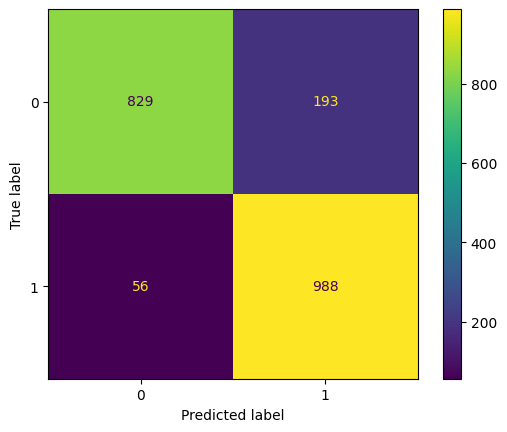

In [31]:
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtc_m1_model.classes_)
disp.plot();

# Now let's fine tune hyperparametr and retrain

In [15]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING) 

n_trials = 100

def objective(trial):
    # Suggest hyperparameters
    params = {
        "max_depth": trial.suggest_int("max_depth", 2, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "criterion": trial.suggest_categorical("criterion", ["entropy", "gini"]),
        "random_state":rs
    }

    model = DecisionTreeClassifier(**params)
    model = model.fit(X=X_train, y=y_train)
    y_pred = model.predict(X=X_test)

    acc = accuracy_score(y_test, y_pred)

    return acc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=n_trials, n_jobs=1)

In [16]:
dtc_m2_model = DecisionTreeClassifier(**study.best_params)
dtc_m2_model = dtc_m2_model.fit(X=X_train, y=y_train)
y_pred = dtc_m2_model.predict(X=X_test)

# Metrics
dtc_m2_metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred)
}

print(dtc_m2_metrics)
# Logging to mlflow
# mlflow_logging(study.best_params, dtc_m2_metrics, model_name, dtc_m2_model)

{'accuracy': 0.8731848983543078, 'f1': 0.8825112107623319, 'recall': 0.9425287356321839, 'precision': 0.8296795952782462}


              precision    recall  f1-score   support

           0       0.93      0.80      0.86      1022
           1       0.83      0.94      0.88      1044

    accuracy                           0.87      2066
   macro avg       0.88      0.87      0.87      2066
weighted avg       0.88      0.87      0.87      2066

ROC-AUC: 0.8724385361135479


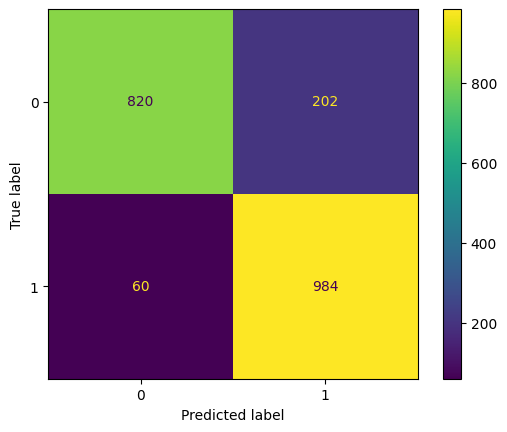

In [17]:
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtc_m2_model.classes_)
disp.plot();

## Lets try random forest

In [18]:
from sklearn.ensemble import RandomForestClassifier

model_name = "random_forest"

rfc_m1_params = {
    "n_estimators":50, "criterion":"gini", "max_depth":10, "class_weight":'balanced_subsample', "random_state":rs
}

y_train_rev = y_train.ravel()
y_test_rev = y_test.ravel()

rfc_m1_model = RandomForestClassifier(**rfc_m1_params)
rfc_m1_model = rfc_m1_model.fit(X_train, y_train_rev)
y_pred = rfc_m1_model.predict(X_test)

# Metrics
rfc_m1_metrics = {
    "accuracy": accuracy_score(y_test_rev, y_pred),
    "f1": f1_score(y_test_rev, y_pred),
    "recall": recall_score(y_test_rev, y_pred),
    "precision": precision_score(y_test_rev, y_pred)
}

print(rfc_m1_metrics)
# Logging to mlflow
# mlflow_logging(rfc_m1_metrics, rfc_m1_metrics, model_name, rfc_m1_model)

{'accuracy': 0.8407550822846079, 'f1': 0.8533214444939813, 'recall': 0.9166666666666666, 'precision': 0.7981651376146789}


              precision    recall  f1-score   support

           0       0.90      0.76      0.83      1022
           1       0.80      0.92      0.85      1044

    accuracy                           0.84      2066
   macro avg       0.85      0.84      0.84      2066
weighted avg       0.85      0.84      0.84      2066

ROC-AUC: 0.8399380300065231


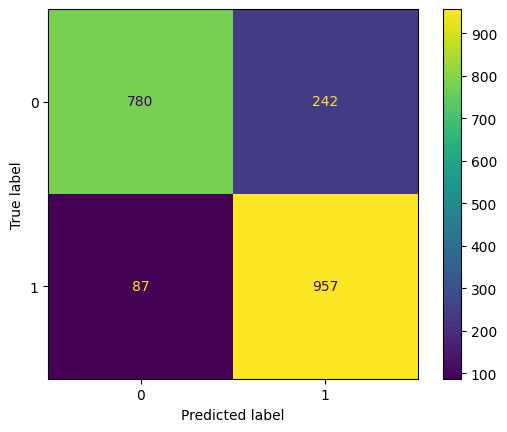

In [19]:
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc_m1_model.classes_)
disp.plot();

## Let's optimize the hyperparameters 

In [23]:
def objective(trial):
    # Suggest hyperparameters
    params = {
        "max_depth": trial.suggest_int("max_depth", 2, 20),
        "n_estimators": trial.suggest_int("n_estimators", 100, 300),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "criterion": trial.suggest_categorical("criterion", ["entropy", "gini", "log_loss"]),
        "random_state":rs
    }

    model = RandomForestClassifier(**params, n_jobs=-1)
    model = model.fit(X_train, y_train_rev)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test_rev, y_pred)

    return acc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=n_trials, n_jobs=1)

In [24]:
rfc_m2_model = RandomForestClassifier(**study.best_params)
rfc_m2_model = rfc_m2_model.fit(X=X_train, y=y_train_rev)
y_pred = rfc_m2_model.predict(X=X_test)

# Metrics
rfc_m2_metrics = {
    "accuracy": accuracy_score(y_test_rev, y_pred),
    "f1": f1_score(y_test_rev, y_pred),
    "recall": recall_score(y_test_rev, y_pred),
    "precision": precision_score(y_test_rev, y_pred)
}

print(rfc_m2_metrics)
# Logging to mlflow
# mlflow_logging(study.best_params, rfc_m2_metrics, model_name, rfc_m2_model)

{'accuracy': 0.8964181994191674, 'f1': 0.9040358744394619, 'recall': 0.9655172413793104, 'precision': 0.8499156829679595}


              precision    recall  f1-score   support

           0       0.96      0.83      0.89      1022
           1       0.85      0.97      0.90      1044

    accuracy                           0.90      2066
   macro avg       0.90      0.90      0.90      2066
weighted avg       0.90      0.90      0.90      2066

ROC-AUC: 0.8956744719616709


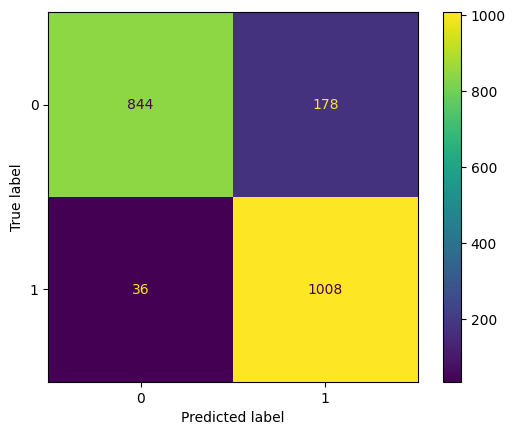

In [25]:
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc_m2_model.classes_)
disp.plot();